# Классификация изображений персонажей сериала "The Simpsons"

Сегодня нам предстоить помочь телекомпании FOX в обработке их контента. Сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. Нам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.

Данный проект является учебным с возможностью проверить качество своей модели, послав сабмит на Kaggle.


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузим-необходимые-библиотеки-и-ознакомимся-с-датасетом" data-toc-modified-id="Загрузим-необходимые-библиотеки-и-ознакомимся-с-датасетом-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузим необходимые библиотеки и ознакомимся с датасетом</a></span></li><li><span><a href="#Построение-нейросети" data-toc-modified-id="Построение-нейросети-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Построение нейросети</a></span></li><li><span><a href="#Ну-и-что-теперь-со-всем-этим-делать?" data-toc-modified-id="Ну-и-что-теперь-со-всем-этим-делать?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Ну и что теперь со всем этим делать?</a></span></li><li><span><a href="#Submit-на-Kaggle" data-toc-modified-id="Submit-на-Kaggle-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Submit на Kaggle</a></span></li><li><span><a href="#AlexNet" data-toc-modified-id="AlexNet-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>AlexNet</a></span></li></ul></div>

### Загрузим необходимые библиотеки и ознакомимся с датасетом

In [ ]:
import time
# from multiprocessing.pool import ThreadPool
from pathlib import Path

import numpy as np
import pandas as pd
import pickle
# from skimage import io
from PIL import Image

import matplotlib.pyplot as plt
# from matplotlib import colors
%matplotlib inline

from tqdm import tqdm_notebook, trange
from tqdm.autonotebook import tqdm

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models
import torchvision.transforms.functional as F

In [ ]:
# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [1]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from ipykernel import kernelapp as app


CUDA is available!  Training on GPU ...


Добавим воспроизводимости:

In [3]:
SEED = 12345
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

Подключим Гугл-диск

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Посмотрим, как называется папка гугл-диска


In [5]:
!ls /content/gdrive/

MyDrive


In [6]:
!ls -l /content/gdrive/MyDrive/journey-springfield.zip

-rw------- 1 root root 546224286 Nov 21 20:42 /content/gdrive/MyDrive/journey-springfield.zip


Распакуем файлы на гугл-диск.

In [7]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

Посмотрим, что за файлы распаковались

In [8]:
!ls

characters_illustration.png  sample_data	    testset
gdrive			     sample_submission.csv  train


In [9]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Nov 27 12:48:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых нам будет необходимо предсказать класс.

In [77]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже мы исспользуем враппер над датасетом для удобной работы. Нам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.

Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  `_prepare_sample`) 

In [78]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

  
    def __getitem__(self, index):
            # для преобразования изображений в тензоры PyTorch и нормализации входа
            transformation = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
            # аугментация для обучающей выборки
            augmentations = transforms.RandomChoice([
                transforms.Compose([
                    transforms.Resize(size=RESCALE_SIZE, max_size=301),
                    transforms.CenterCrop(size=RESCALE_SIZE),
                    transforms.RandomCrop(RESCALE_SIZE)
                ]),
                transforms.RandomRotation(degrees=(-25, 25)),
                transforms.RandomHorizontalFlip(p=1)
            ])

            if self.mode == 'train':     
                transformation = transforms.Compose([
                    transformation,
                    augmentations
                ]) 
            
            
            x = self.load_sample(self.files[index])
            x = self._prepare_sample(x)
            x = np.array(x / 255, dtype='float32')
            x = transformation(x)
            
            if self.mode == 'test':
                return x
            else:
                label = self.labels[index]
                label_id = self.label_encoder.transform([label])
                y = label_id.item()
                return x, y  
    
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [79]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


In [80]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [81]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

Посмотрим на распределение классов.

In [82]:
pd.Series(train_val_labels).value_counts().to_frame('count').reset_index()

,index,count
0,homer_simpson,2246
1,ned_flanders,1454
2,moe_szyslak,1452
3,lisa_simpson,1354
4,bart_simpson,1342
5,marge_simpson,1291
6,krusty_the_clown,1206
7,principal_skinner,1194
8,charles_montgomery_burns,1193
9,milhouse_van_houten,1079


Видим, что классы очень несбалансированы.

"Откопируем картинки малочисленных классов менее 100 картинок из выборки train, так чтобы число на каждый малочисленный класс было не менее 100.

Если мы сделаем oversampling, - возьмем картинки из всей выборки до разбиения ее на 'train' и 'val' то скорее всего в train попадут и картинки из выборки val, а мы этого не хотим.

При этом у нас все так же будет работать аугментация, да картинки в малочисленных классах будут одинаковыми, но при каждой загрузке одни и те же картинки будут по разному аугментироваться, и будут отличаться друг от друга. Конечно такого разнообразия как у изначально многочисленных классов не будет, но это лучше чем ничего.

Напишем такую функцию вручную. Нам не надо копировать картинки, нам надо копировать пути к картинкам !" (с) с коммента пользователя Антон Дмитриевич Ширяев на Stepic.



In [83]:
train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]

pd.Series(train_labels).value_counts()

homer_simpson               1684
ned_flanders                1090
moe_szyslak                 1089
lisa_simpson                1015
bart_simpson                1006
marge_simpson                968
krusty_the_clown             904
principal_skinner            895
charles_montgomery_burns     895
milhouse_van_houten          809
chief_wiggum                 739
abraham_grampa_simpson       685
sideshow_bob                 658
apu_nahasapeemapetilon       467
kent_brockman                373
comic_book_guy               352
edna_krabappel               343
nelson_muntz                 269
lenny_leonard                233
mayor_quimby                 185
waylon_smithers              136
maggie_simpson                96
groundskeeper_willie          91
barney_gumble                 80
selma_bouvier                 77
carl_carlson                  74
ralph_wiggum                  67
patty_bouvier                 54
martin_prince                 53
professor_john_frink          49
snake_jail

In [84]:
# Объявим полезные функции
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

def create_dct_from_labels(train_val_labels):
    """Функция создает из list train_val_labels, содержащего метки классов
    соответсвующим картинкам из выборки, словарь dict с ключами соответсвующими
    названиям классов, и значениями, соответвующими колчеству этих классов в 
    list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

In [85]:
# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [1]:
# Посмотрим, что у нас получилось.
# print_dct(dct_path_train)
# Лучше посмотреть и закомментировать, чем посмотреть и оставить.

In [87]:
# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [88]:
# Проверим что получилось 
# for person in dct_path_train:
#     print(f"{person}\t{len(dct_path_train[person])}")
# Лучше посмотреть и закомментировать, чем посмотреть и оставить.

In [89]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

# выведим на печать класс:количесвто картинок для train должно быть примерно 75 %
print_dct(create_dct_from_labels(new_train_label))

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


Отлично, мы видим, что теперь все классы имеют минимум 100 картинок. У нас получилось.

In [90]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(new_train_files, mode='train')

In [91]:
# uncomment if have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

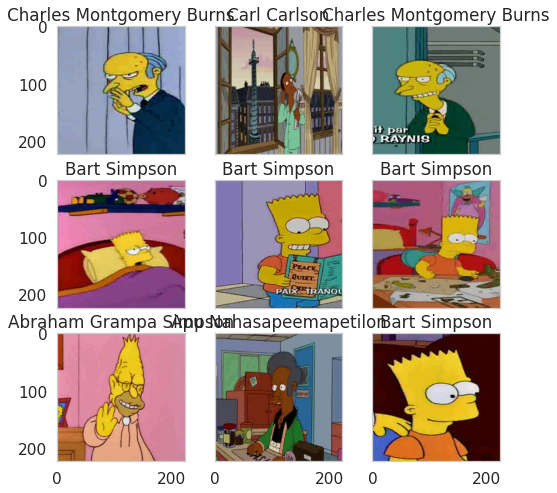

In [92]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    
# fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
#                         sharey=True, sharex=True)
# for fig_x in ax.flatten():
#     random_characters = int(np.random.uniform(0,1000))
#     im_val, label = val_dataset[random_characters]
#     img_label = " ".join(map(lambda x: x.capitalize(),\
#                 val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
#     imshow(im_val.data.cpu(), \
#           title=img_label,plt_ax=fig_x, pad=0.5)

### Построение нейросети

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание

*Описание слоев*:

1. размерность входа: 3x224x224 
2. размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [93]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [94]:
# Обучение модели по эпохам
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [95]:
# Предсказания модели по эпохам
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [96]:
# Обучение модели
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    
        # Сохранение модели на Google Drive
        model_file = '/content/drive/MyDrive/MyModels/the_simpsons_simple_cnn_model.pth'
        torch.save(model.state_dict(), model_file)
        print('Model saved to Google Drive!')
    
    return history

In [2]:
# Предсказание модели
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [98]:
# Количество классов
n_classes = len(np.unique(train_val_labels))

# Инициализация простой модели
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [100]:
%prun history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=8)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.3585318723350066

Epoch 001 train_loss: 2.3585     val_loss 1.4586 train_acc 0.3590 val_acc 0.6058
loss 1.2264020744390338

Epoch 002 train_loss: 1.2264     val_loss 1.0545 train_acc 0.6636 val_acc 0.7243
loss 0.872035763900673

Epoch 003 train_loss: 0.8720     val_loss 0.8748 train_acc 0.7603 val_acc 0.7694
loss 0.6910578043477075

Epoch 004 train_loss: 0.6911     val_loss 0.8062 train_acc 0.8067 val_acc 0.7948
loss 0.5989020355770334

Epoch 005 train_loss: 0.5989     val_loss 0.7450 train_acc 0.8319 val_acc 0.8093
loss 0.510559320363174

Epoch 006 train_loss: 0.5106     val_loss 0.7736 train_acc 0.8592 val_acc 0.8078
loss 0.46960341316756976

Epoch 007 train_loss: 0.4696     val_loss 0.7173 train_acc 0.8707 val_acc 0.8324
loss 0.4265993453604981

Epoch 008 train_loss: 0.4266     val_loss 0.7591 train_acc 0.8777 val_acc 0.8271
loss 0.40400045850554267

Epoch 009 train_loss: 0.4040     val_loss 0.7708 train_acc 0.8827 val_acc 0.8271
loss 0.3650069509752229

Epoch 010 train_loss:

Построим кривые обучения

In [101]:
loss, acc, val_loss, val_acc = zip(*history)

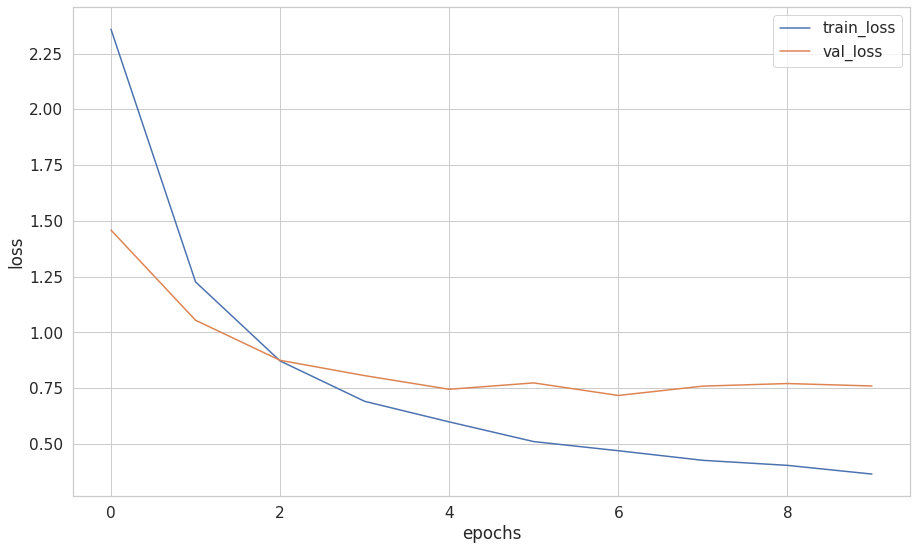

In [102]:
plt.figure(figsize=(12, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Данный проект - учебный. И он оценивался по результатам, который наберет сабмит на Kaggle. Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы `eval` у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит `softmax`, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [103]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [104]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [105]:
idxs = list(range(len(val_dataset)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [106]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [107]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]
actual_class = [label_encoder.classes_[i] for i in actual_labels]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратим внимание, что метрика, которую необходимо оптимизировать в конкурсе --- `f1-score`. Вычислим целевую метрику на валидационной выборке.

In [108]:
from sklearn.metrics import f1_score

f1 = f1_score(actual_labels, y_pred, average='weighted')
print(f'F1-score = {f1}')

0.8229611903196415

**Данное значение метрики F1 для валидационной выбоки.**

Сделаем визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах.

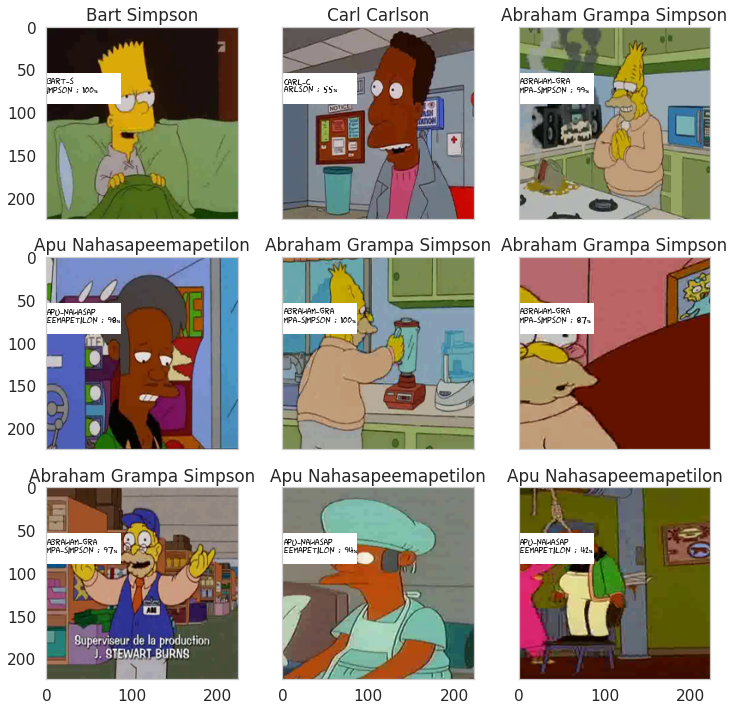

In [109]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуем найти те классы, которые сеть не смогла расспознать.

In [110]:
actual_ser = pd.Series(actual_class, name='actual_class')
predicted_ser = pd.Series(preds_class, name='predicted_class')
diff_table = pd.DataFrame({'actual':actual_ser, 'predicted':predicted_ser})
diff_table['differense'] = diff_table['actual'] != diff_table['predicted']
diff_table[diff_table.differense == True]['actual'].value_counts()

bart_simpson                88
charles_montgomery_burns    78
homer_simpson               66
lisa_simpson                65
moe_szyslak                 52
abraham_grampa_simpson      46
sideshow_bob                43
milhouse_van_houten         31
nelson_muntz                30
lenny_leonard               30
marge_simpson               29
ned_flanders                28
edna_krabappel              26
comic_book_guy              25
chief_wiggum                24
principal_skinner           24
mayor_quimby                23
krusty_the_clown            23
maggie_simpson              17
apu_nahasapeemapetilon      17
barney_gumble               16
waylon_smithers             12
martin_prince               12
kent_brockman               12
ralph_wiggum                11
professor_john_frink        11
carl_carlson                11
groundskeeper_willie        10
selma_bouvier                9
agnes_skinner                7
patty_bouvier                6
otto_mann                    6
cletus_s

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [111]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)


probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [112]:
! ls 

AlexNet_fine_tune_inspect.pth
characters_illustration.png
gdrive
label_encoder.pkl
sample_data
sample_submission.csv
simple_alexnet_25epoches_64batch.csv
simple_cnn_baseline_8batch_2epochs_OverSampler_augmentations___.csv
simple_cnn_baseline_8batch_50epochs_lr3eminus4.csv
testset
train


In [113]:
import pandas as pd
# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
SAMPLE = Path('sample_submission.csv')
my_submit = pd.read_csv(SAMPLE)
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [115]:
my_submit.to_csv('simple_cnn_baseline_8batch_10epochs_OverSampler_augmentations_final.csv', index=False)

In [116]:
from google.colab import files
with open('simple_cnn_baseline_8batch_10epochs_OverSampler_augmentations_final.csv', 'r') as f:
  files.download('/content/simple_cnn_baseline_8batch_10epochs_OverSampler_augmentations_final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Простая модель у меня дала наилучший скор при значениях learning rate 3e-4, батче 8 и 50 эпохах. 
- **Скор данной модели на Kaggle 0.9458.**

**!!!** В тетради воспроизвожу для скорости отработки версию с learning по умолчанию, батче 8 и 10 эпох. 
- **Скор данной модели на Kaggle 0.92986.**

Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


### AlexNet

AlexNet состоит из 5 сверточных слоев, 3 MaxPool слоев и 2 FullyConnected слоев в конце. В последнем пулинг слое окна, из которых берется максимум, пересекаются за счет того, что stride=2. Это изменение по сравнению с традиционным пулингом помогло снизить ошибку на 0.4%.

По сути AlexNet это самая базовая архитектура для сверточной сети после LeNet.


Следующая функция будет использоваться для обучения модели. Аргументы:  
* model $-$ нейросеть
* loss $-$ оптимизируемая функция (criterion, cost function, objective)
* optimizer $-$ оптимизационный алгоритм
* scheduler $-$ политика изменения learning_rate
* num_epochs $-$ количество итераций обучения

In [52]:
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=2,
    )
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}


In [53]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if train_on_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "val":

                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
                # Сохранение модели на Google Drive
                model_file = '/content/drive/MyDrive/MyModels/the_simpsons_alexnet_model.pth'
                torch.save(model.state_dict(), model_file)
                print('Model saved to Google Drive!')
    

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

Функция для отрисовки тестовых изображений и предсказаний для них:

In [55]:
from torch.autograd import Variable

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if train_on_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dataloaders['val'].label_encoder.inverse_transform([label])[0][preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Функция для измерения точности модели на валидационном датасете

In [56]:
def evaluate(model):
    model.eval()
    
    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if train_on_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']

In [57]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs


Загрузим модель.

In [58]:
alexnet_model = models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Посмотрим, что внутри.

In [59]:
alexnet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Видим, что на вход классификатору (classifier) подаётся 9216 признаков. Это и будет размер входа для нашего нового классификатора.

Сконфигурируем - изменим FC-слой и зададим cost function и оптимизирующий алгоритм:

(по умолчанию backpropagation распространяется на все слои, поэтому здесь мы только заменяем FC-слой на свой классификатор)

In [60]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
alexnet_model.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
alexnet_model.to(DEVICE)

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.Adam(alexnet_model.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [61]:
alexnet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=42, bias=True)
)

In [62]:
model, losses = train_model(alexnet_model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/264 [00:00<?, ?it/s]

val iter::   0%|          | 0/82 [00:00<?, ?it/s]

Training complete in 73m 18s
Best val Acc: 0.931792


In [63]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=42, bias=True)
)

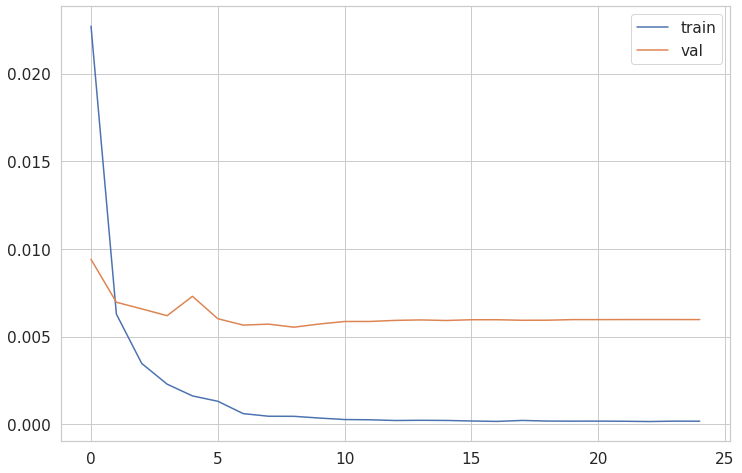

In [64]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [65]:
torch.save(model.state_dict(), 'AlexNet_fine_tune_inspect.pth')

In [66]:
model.load_state_dict(torch.load('AlexNet_fine_tune_inspect.pth'))

<All keys matched successfully>

In [67]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

Accuracy: 0.9308


Проверим F1 на валидационной выборке:

In [73]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

len(val_dataset)

idxs = list(range(len(val_dataset)))

imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]
actual_class = [label_encoder.classes_[i] for i in actual_labels]

preds_class = [label_encoder.classes_[i] for i in y_pred]

f1_score(actual_labels, y_pred, average='weighted')

0.929951101401022

In [71]:
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))   # инверсивно трансформим из цифорок классов в string
test_filenames = [path.name for path in test_dataset.files]

my_submit_alexnet_test = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
print(my_submit_alexnet_test.head())

           Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon


Сделаем сабмит.

In [75]:
from google.colab import files

my_submit_alexnet_test.to_csv('simple_alexnet_25epoches_64batch.csv', index=False)

with open('simple_alexnet_25epoches_64batch.csv', 'r') as f:
  files.download('/content/simple_alexnet_25epoches_64batch.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Данная модель на Kaggle получила `f1-score` 0.97874